# CoastSat - Shoreline Extraction for Grassy Beach

Key Notes:
- Python version 3.8
- Environment: CoastSat_Jul22
- CoastSat: https://github.com/kvos/CoastSat
- Locations: Grassy Beach/Bay, King Island
- GitHub project: https://github.com/james-th94/NaturalCoastalProcessesWSE

Last updated 25/8/22.

## 1 - Python Setup

In [1]:
## 1.0 Change Directory 
## Change the working directory to the CoastSat folder within the project using the Python package, os. 
## Project details are found at https://github.com/james-th94/NaturalCoastalProcessesWSE.
DIR = 'C:/Users/s5245653/OneDrive - Griffith University/Projects/GrassyWaves/CoastSat'
import os
os.chdir(DIR)

## 2.0 Load Modules
## Ensure the Anaconda environment is first set to "CoastSat_Jul22" for these packages to work. 
## CoastSat package details can be found at https://github.com/kvos/CoastSat. 
## Version 1 of CoastSat was used, before Landsat 9 data was added (Version 2.0).

# CoastSat Version 1
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
# Scientific Modules
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
# Geospatial Modules
from shapely.geometry import LineString
import geopandas as gpd
# Other Modules
import pickle # Pickle allows for the saving and loading of Python objects (e.g. dictionaries, arrays)
import warnings
warnings.filterwarnings("ignore")

## 2 - Initial CoastSat Settings

In [2]:
## 2.1 Spatial Range
## Choose the latitude/longitude boundaries of the CoastSat domain, then 
## convert to be the smallest rectangle with sides parallel to the coordinate axes
polygon = [[[144.046,-40.0645],
            [144.061,-40.0645],
            [144.061,-40.0725],
            [144.046,-40.0725]]]
polygon = SDS_tools.smallest_rectangle(polygon)

## 2.2 Date Range
## Choose the start date and end date for Google Earth Engine satellite retrieval.
dates = ['1980-01-01', '2022-07-08']

## 2.3 Satellite Missions
## Choose the satellites you want to retrieve images for from the list; [L5, L7, L8, S2].
## A landsat collection variable is also required - see CoastSat GitHub for details. 
sat_list = ['S2']
collection = 'C01'

## 2.4 Data Location
## Set the location of the CoastSat data using a sitename. 
## Recommend using a sitename which varies with inputs (e.g. date range). 
## The filepath will be where the data is stored.
sitename = 'Grassy_' + dates[0] + '_' + dates[1]
filepath = os.path.join(os.getcwd(), 'data')

## 2.5 Save Inputs
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
          'landsat_collection': collection}

## 2.6 Settings for the shoreline extraction
settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'output_epsg': 3857,        # epsg code of spatial reference system desired for the output   
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 6000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 150,         # radius (in metres) of the buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    # add the inputs defined previously
    'inputs': inputs,
}

## 2.7 Figure Settings
FIGSIZE = [8,6]

## 3 - Image Retrieval from Google Earth Engine (Skip this step if already have data)
Only need to perform this once for each project. This section will retrieve images from GEE based on your input variables. Set to markdown script so it is not accidentally run. 

#### 3.1 Check Available Images
Uses CoastSat's SDS_download module to quickly check how many images your inputs will download. Results will show how many images are available. Note: number of images downloaded may not match the number that are displayed here, particularly for Sentinel-2 data. 

    SDS_download.check_images_available(inputs);

#### 3.2 Retrieve Images - SLOW
Slowest step in the process. Metadata will be downloaded for all images that match the request. 

    metadata = SDS_download.retrieve_images(inputs)

#### 3.3 - Load the satellite metadata
Load the metadata file associated with the satellite images from step 3.2.

In [3]:
metadata = SDS_download.get_metadata(inputs)

## 4 - Shoreline Detection
Script to prepare for mapping, map and clean shorelines from satellite images.preprocess images and create a reference shoreline in preparation of shoreline detction. Set to markdown script so it is not accidentally run. 

#### 4.1 [OPTIONAL] Preprocess images - SLOW
Cloud masking, pansharpening/down-sampling. 

    SDS_preprocess.save_jpg(metadata, settings)*


#### 4.2 [OPTIONAL] Create CSV file for all images
Manually-added section to record image downloading. 

    os.chdir(DIR)
    for root, directory, files in os.walk('data/' + sitename + '/jpg_files/preprocessed'):
        file_list = files
    date_list = []; 
    satellite_list = [];
    for files in file_list:
        date_list.append(files[0:19])
        satellite_list.append(files[20:22])
    df = pd.DataFrame(satellite_list, date_list)
    df = df.truncate(after = '2021-01-01')
    df.index = pd.to_datetime(df.index, format = '%Y-%m-%d-%H-%M-%S')

Image counts:

    S2, L5, L7, L8 = 0, 0, 0, 0 
    for i in df[0][:]:
        if i == 'S2':
            S2 += 1
        if i == 'L5':
            L5 += 1
         if i == 'L7':
             L7 += 1
         if i == 'L8':
             L8 += 1
    os.chdir(DIR)
    df.to_csv('images_list.csv')

#### 4.3 [OPTIONAL] Create a reference shoreline 
This step allows the user to define a reference shoreline to help identify outliers and false detections by applying a max_distance from the reference shoreline.

    settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
    settings['max_dist_ref'] = 60
    
#### 4.4 - Map Shorelines
Extract shorelines from all images (also saves output.pkl and shorelines.kml). Here, the output variable is created which contains all the shoreline data from the CoastSat process. Saving the output file is important for future use. Pickle is used in the next steps to save the output, which allows it to be loaded directly for future fast-tracking of the CoastSat process. Set to markdown script so it is not accidentally run.

    output = SDS_shoreline.extract_shorelines(metadata, settings)
    
#### 4.5 Clean Shorelines
Remove duplicates (images taken on the same date by the same satellite) and inaccurate georeferencing (threshold is set here - 10 m is standard).

    output = SDS_tools.remove_duplicates(output)
    output = SDS_tools.remove_inaccurate_georef(output, 10)
    
Can also manually remove any bad values, or shorten output based on a datetime in the output variable.

    bad_values = [_, _, ...]
    for i in output:
       a = str(i)
       output[a] = [output[a][j] for j in range(len(output[a])) if j not in bad_values]  
     
    A = _
    last_date_value = len(output['dates']) - A
    for i in output:
        a = str(i)
        output[a] = [output[a][j] for j in range(0, last_date_value + 1)]
        
#### 4.6 Save Shoreline Output Data
Pickle module is used to save the output variable to a python (pickle, .pkl) file. Useful to save at any point (e.g. after cleaning the shorelines etc.). Added manually to CoastSat method.
Change "output.pkl" to "X.pkl" for any other X of choice - e.g. output3.pkl.

    for satname in metadata.keys():
         filepath = SDS_tools.get_filepath(settings['inputs'],satname)
         filepath_data = settings['inputs']['filepath']
         sitename = settings['inputs']['sitename']
         filepath = os.path.join(filepath_data, sitename)
         with open(os.path.join(filepath, sitename + '_output.pkl'), 'wb') as f:
             pickle.dump(output, f)

#### 4.7 - Load Previously Saved Shoreline Data
Use the pickle module to reload the output dictionary created by step 5 (shoreline detection) - i.e. the already mapped shorelines.

In [4]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output3.pkl'), 'rb') as f:
    output = pickle.load(f)
output.keys() # displays the dictionary keys from the output dictionary

dict_keys(['dates', 'shorelines', 'filename', 'cloud_cover', 'geoaccuracy', 'idx', 'MNDWI_threshold', 'satname'])

In [24]:
for i in range(380,419):
    if output['satname'][i] == 'L7':
        print(output['dates'][i])

2020-01-29 23:49:53+00:00
2020-03-10 23:41:33+00:00
2020-07-07 23:40:44+00:00
2020-09-09 23:36:41+00:00


## 5 - Save and View Shorelines
Save a GeoJSON file for GIS applications from the output dictionary variable. The user can choose this to be a point or line GeoJSON layer. The SDS_tools module is used. Note: When adding this layer to your GIS software (e.g. QGIS), ensure the layer coordinate reference system (crs) "projection" matches that of the settings chosen in CoastSat (default: "3857"). Change the "X" in the gdf.to_file to control how this layer is named.

Here matplotlib.pyplot is used to plot the shorelines as well. However, it is recommened to use GIS software for more detailed map plots.

    geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
    gdf = SDS_tools.output_to_gdf(output, geomtype)
    gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
    # save GEOJSON layer to file
    gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_X_%s.geojson'%(sitename,geomtype)),
                                    driver='GeoJSON', encoding='utf-8')

    #plt.ion()
    fig = plt.figure(figsize=FIGSIZE, tight_layout=True)
    plt.axis('equal')
    plt.xlabel('Eastings')
    plt.ylabel('Northings')
    plt.grid(linestyle=':', color='0.5')
    for i in range(len(output['shorelines'])):
        sl = output['shorelines'][i]
        date = output['dates'][i]
        plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
    # plt.legend # legend removed to help with plotting

## 6 - Transects
This section creates transect data from the shoreline data, useful for assessing shoreline change with time at specific locations along the beach.

See the CoastSat github for options on how to define transect locations. Here, QGIS was used to manually create transect locations every 50 m along the beach.

Transects are plotted to check the locations are correct, and their origin is at the landward extend. Again, for figures, it is better to use GIS software to plot transect locations over a map.

#### 6.1 - Load and plot transect locations

In [5]:
geojson_file = os.path.join(filepath, 'Transects', 'Transects_Grassy.geojson')
transects = SDS_tools.transects_from_geojson(geojson_file)

25 transects have been loaded


    fig = plt.figure(figsize=FIGSIZE, tight_layout=True)
    plt.axis('equal')

    plt.xlabel('Eastings')
    plt.ylabel('Northings')
    plt.grid(linestyle=':', color='0.5')

    for i in range(len(output['shorelines'])):
         sl = output['shorelines'][i]
         date = output['dates'][i]
         plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
    for i,key in enumerate(list(transects.keys())):
        plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
        plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
        plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                    va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

#### 6.2 - Transect Time Series
Create a time series of shoreline position along each transect. The along_dist setting variable is able to be modified to choose how much of the beach to sample for each shoreline position. For example, along_dist = 25 means that the 25 m either side of the transect is used to calculate the (median) shoreline position.

This step creates a CSV file with the time-series, dates are in UTC time.

    settings['along_dist'] = 25
    cross_distance = SDS_transects.compute_intersection(output, transects, settings)

Option to plot the transect time series. Best when there are only a few transects, otherwise the plot is cluttered.

    fig = plt.figure(figsize=FIGSIZE, tight_layout=True)
    gs = gridspec.GridSpec(len(cross_distance),1)
    gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
    for i,key in enumerate(cross_distance.keys()):
        if np.all(np.isnan(cross_distance[key])):
            continue
        ax = fig.add_subplot(gs[i,0])
        ax.grid(linestyle=':', color='0.5')
        ax.set_ylim([-50,50])
        ax.plot(output['dates'], cross_distance[key]- np.nanmedian(cross_distance[key]), '-o', ms=6, mfc='w')
        ax.set_ylabel('distance [m]', fontsize=12)
        ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
                va='top', transform=ax.transAxes, fontsize=14) 

#### 6.3 - Tide Data for Correction
Tide data is used to perform a water level height correction to effectively remove the effect of tides. However, this proxy for water level does not include wave setup/runup data. This step requires beach slope information for the study site, and tide data. Mean water level is used a proxy for mean sea-level.

    beach_slope = 0.045

    # Load tide data
    tide_file = 'data/' + sitename + '/Grassy_tides.csv' # Above LAT
    tide_data = pd.read_csv(tide_file, parse_dates=['dates'])
    dates_ts = [_.to_pydatetime() for _ in tide_data['dates']]
    tides_ts_LAT = np.array(tide_data['tide'])
    tides_ts = tides_ts_LAT - np.mean(tides_ts_LAT)

    # Get tide levels at time of images
    dates_sat = output['dates']
    tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

    # Plot tide data
    fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.plot(tide_data['dates'], tides_ts, '-', color='0.6', label='all time-series')
    ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
    ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition')
    ax.legend()

#### 6.4 - Tidally-Corrected Shoreline Data
Create a tidally-corrected shoreline position dataset for each transect, and save to a .csv file. Also creates a dataframe of tidally-corrected transects, "df". This is useful for further analysis.

    new_filename = 'transect_time_series_tidally_corrected_for_test.csv'

    reference_elevation = 0
    cross_distance_tidally_corrected = {}
    for key in cross_distance.keys():
        correction = (tides_sat-reference_elevation)/beach_slope
        cross_distance_tidally_corrected[key] = cross_distance[key] + correction

    out_dict = dict([])
    out_dict['dates'] = dates_sat
    for key in cross_distance_tidally_corrected.keys():
        out_dict['Transect '+ key] = cross_distance_tidally_corrected[key]
    df = pd.DataFrame(out_dict).set_index('dates') # Creates a dataframe of tidally-corrected transect data
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      new_filename)
    df.to_csv(fn, sep=',')
    print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

## 7 - Plotting Transect Data
Tidally corrected transect time-series data is best visualised through a x,y scatter/line plot. Change the Transect_file location to get your time-series file.

Here, the eastern transect is plotted (since 2015 only) against its monthly mean and a sine curve that has a minimum during winter and maximum during summer.
- This shows a clear seasonal trend, with the sine curve displaying a reasonable fit to the data

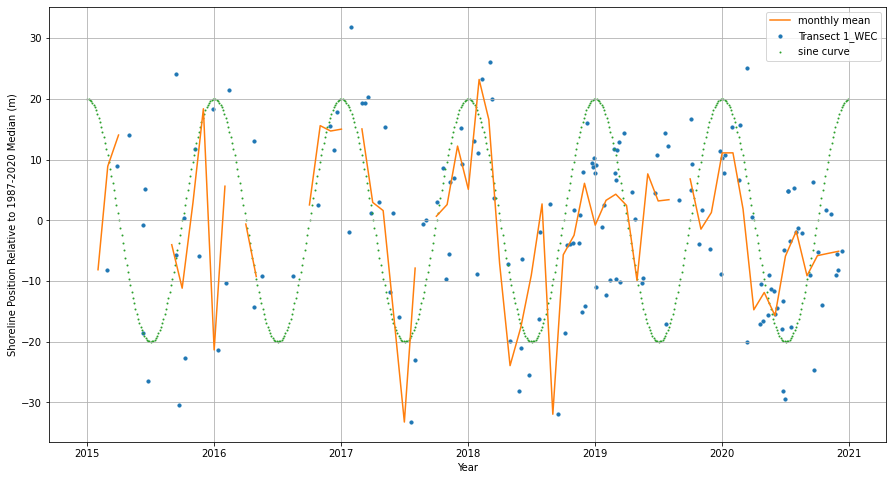

In [6]:
# Get Data with pandas read_csv function, and set index to a datetime index.
new_filename = 'transect_time_series_tidally_corrected_for_test.csv'
Transect_file = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      new_filename)
df = pd.read_csv(Transect_file, header = 'infer', index_col = 'dates')
df.index = pd.to_datetime(df.index)

# Subtract the median shoreline position, and choose relevant time period, and transect.
df2 = df - df.median()
df2 = df2.truncate(before = '2015-01-01')
Transect_of_interest = 'Transect 1_WEC'
df_monthly = df2.resample('MS').mean()

# PLOT
fig, ax = plt.subplots(figsize = (15,8))
# Plot Transect Time Series
ax.scatter(x = df2.index, y = df2[Transect_of_interest], s = 10, label = Transect_of_interest, color = 'C0')
ax.plot(df_monthly[Transect_of_interest], color = 'C1', label = 'monthly mean')

# Create and plot sine function to match seasonal cyclone
amplitude = 20 # metres
years = np.arange(2015, 2021, 0.01)
years_2 = [datetime(int(i), 1, 1) + timedelta(
    seconds=(datetime(int(i), 1, 1).replace(year=datetime(int(i), 1, 1).year + 1) - datetime(int(i), 1, 1)).total_seconds() * (i - int(i)))
           for i in years]
y1 = amplitude * np.cos(np.multiply(2 * np.pi, years))
ax.scatter(years_2, y1, s = 1, color = 'C2', label = 'sine curve')

ax.set_xlabel('Year')
ax.set_ylabel('Shoreline Position Relative to 1987-2020 Median (m)')
ax.grid()
plt.legend()

# THE END